In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
# from read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas
from postfit_criteria import Postfit
from form_loss_fct import complete_loss_fct, raw_loss_fct
from postfit_measures import Measures
from logspace_grid import generate_grid
# from rebin_fk_data import rebin_fk

In [2]:
# Define global variables
num_obs = 1 #between 1 and 4
REPLICAS  = 3

#HYPERPARAMETERS
preproc = 1
l1 = 6
l2 = 8
l3 = 6

fit_level = 0

lr = 0.01
print(lr)
max_counter = 50
max_Nepochs = 3500

0.01


In [3]:

events = [44.1, 92.7, 68.5, 66.8, 44.3, 21.9]

std_errev = [3.1,2.5,1.7,1.6,2.3,2.9]

sig_sys = std_errev
sig_stat = np.sqrt(events)
binwidths = 100 * 65.6/150 
xlabels = ['mu']
data = events

xvals_per_obs_mu = [100,300,600,1000]
xvals_per_obs = [100,300,600,1000,-300,-100]
xvals_per_obs_mub = [-100,-300,-1000]


In [4]:

cov_matrix = np.array([
    [9.2,-0.32,  0.08, -0.03,  0.00,  0.00],
    [-0.32, 10.2, -0.43,  0.10, -0.01, -0.00],
    [ 0.08, -0.43, 9.6, -0.31,  0.04, -0.02],
    [-0.03,  0.10, -0.31, 22.3,-0.14,  0.01],
    [ 0.00, -0.01,  0.04, -0.14, 12.1,-0.24],
    [ 0.00, -0.00, -0.02,  0.01, -0.24,7.5]
])
sig_sys = np.array(sig_sys)
np.fill_diagonal(cov_matrix, sig_stat**2 + sig_sys**2)
cov_matrix = np.linalg.inv(cov_matrix)
cov_matrix = torch.tensor(cov_matrix, dtype=torch.float32, requires_grad=False)
#Generate MC replicas of data
level0,level1,level2 = generate_MC_replicas(REPLICAS,data,sig_sys,sig_stat)
# Get faserv pdf
pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_vals,14)

[3.1 2.5 1.7 1.6 2.3 2.9]
[6.64078309 9.62808392 8.27647268 8.1731267  6.65582452 4.67974358]
1
[ 1.71553295 -1.26454534  1.53207173  1.92114294  4.56914073  2.29929768] [ -0.81485295  12.39836246  -7.49490971   5.9976043  -14.0127326
  -4.43410531]
2
[ 5.1486571   0.40863827 -0.76499253  1.55782358  0.7378848   3.69870346] [ -7.82841862  -6.13998844 -12.99370655   4.03591186   0.48389115
   2.41270643]
1
[-0.12307286 -1.69901827 -0.16627476  0.63686214 -0.64543977 -3.66048636] [-4.22853097  7.18015706 10.38175883  4.48931474 -6.88197239 -1.50050022]
2
[-3.86324175 -1.03368177  1.62166313 -2.4521717  -0.98768214 -0.32418213] [-6.8756482  -8.36070059 -1.61058029 -1.65415141  4.89648945 -0.36317624]
1
[ 2.13438198  1.69968249 -1.30654106  1.00221559 -2.99914932 -1.07488948] [11.53935395  2.81351991  3.58000894 -3.21781074 11.59597018 -0.8155327 ]
2
[-1.10440391 -2.34209791 -1.32656762  1.38174128 -1.04132481  1.86448975] [ -4.88762944   3.97619743 -15.50124299  17.07829087  -3.91971612
 

In [5]:
if fit_level ==0:
    pred = level0
if fit_level ==1:
    pred = level1
if fit_level ==2:
    pred = level2

[44.1, 92.7, 68.5, 66.8, 44.3, 21.9]
[tensor([ 45.0007, 103.8338,  62.5372,  74.7188,  34.8564,  19.7652]), tensor([39.7484, 98.1811, 78.7155, 71.9262, 36.7726, 16.7390]), tensor([57.7737, 97.2132, 70.7735, 64.5844, 52.8968, 20.0096])]
[tensor([42.3209, 98.1025, 48.7785, 80.3125, 36.0782, 25.8766]), tensor([29.0095, 88.7868, 78.7266, 67.8199, 40.6814, 16.0517]), tensor([51.7817, 98.8473, 53.9457, 83.0444, 47.9358, 32.0010])]


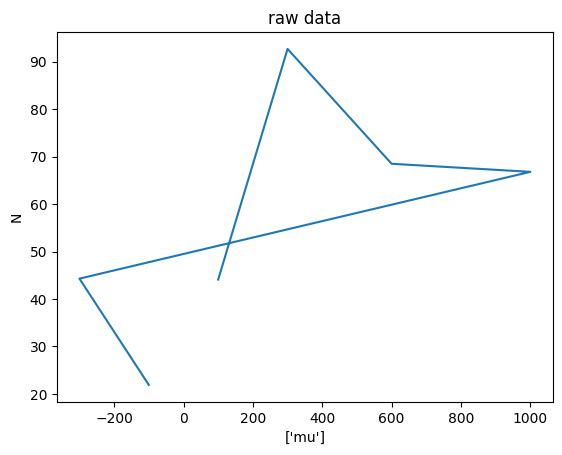

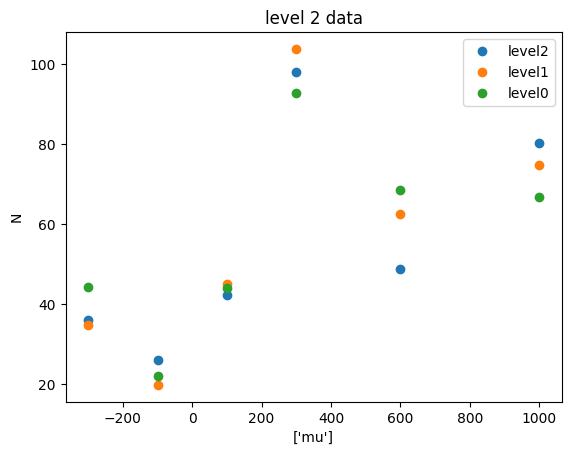

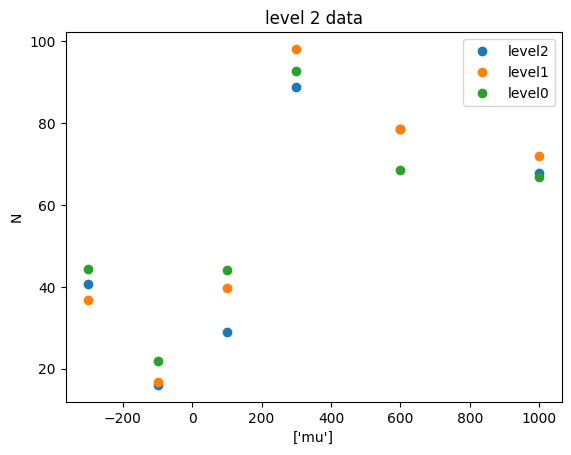

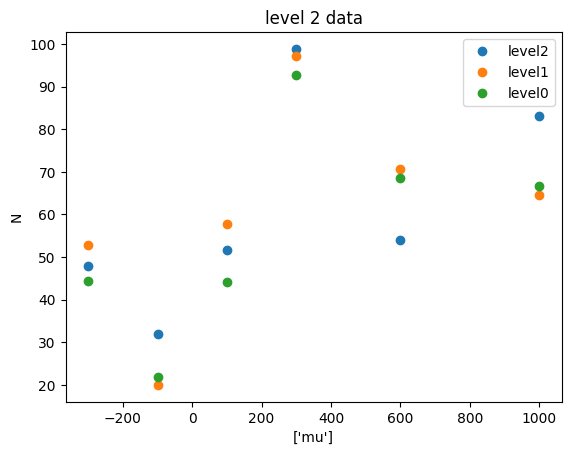

In [6]:
print(data)
print(level1)
print(level2)
plt.plot(xvals_per_obs,data)
plt.xlabel(xlabels)
plt.ylabel('N')
plt.title("raw data")
plt.show()

for i in range(REPLICAS):
    plt.plot(
        xvals_per_obs, level2[i], 'o',label="level2"
    )
    plt.plot(
        xvals_per_obs, level1[i], 'o',label="level1"
    )
    plt.plot(xvals_per_obs, data,'o',label="level0")
    plt.xlabel(xlabels)
    plt.legend()
    plt.ylabel("N")
    plt.title("level 2 data")
    plt.show()


In [7]:
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        self.relu = torch.nn.ReLU()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        y = self.relu(y)
        y = self.hidden3(y)
        # y = self.relu(y)
        # y = torch.nn.functional.softplus(y)
    
        return y

In [8]:
import torch.nn as nn

if preproc == 1:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma):
            super(CustomPreprocessing, self).__init__()

            # self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            # self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            # self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))
            # self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=False ))
            # self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=False ))
            # self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=False))
            self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float32))
            self.register_buffer("beta", torch.tensor(beta, dtype=torch.float32))
            self.register_buffer("gamma", torch.tensor(gamma, dtype=torch.float32))

        def forward(self, x):
            # return self.gamma*(1 - x) ** abs(self.beta) * x ** (1-self.alpha)
            # if self.alpha > 1:
            #     self.alpha=torch(1)
            # alpha = (1 - 0.2)/2 *torch.tanh(self.alpha) + (1 + 0.2)/2
            # beta = (1.9 - 0.1)/2 *torch.tanh(self.alpha) + (1.9 + 0.1)/2
            # beta = abs(self.beta)
            # alpha = 1 - torch.nn.functional.softplus(self.alpha)
            return self.gamma * (1 - x) ** self.beta * x**(1-self.alpha) 
            # return 10 * (1 - x)**2 * x**(1.5) 
            # return  self.gamma*(1 - x) ** self.beta * x**(1-self.alpha) 
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            f_preproc = self.preprocessing(x)
            f_NN = self.mlp(x)
            f_nu = f_preproc * f_NN
            return f_NN
        
        def neuralnet(self, x):
            f_NN = self.mlp(x)
            return f_NN
        
        def preproc(self, x):
            f_preproc = self.preprocessing(x)
            return f_preproc
        


In [9]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix):
        loss = raw_loss_fct(pred,
    data,
    cov_matrix)
        return loss

In [10]:
#Define variables for fit
# x_alpha_more_bins = np.logspace(-5,0,250)
# x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
x_vals = torch.tensor(x_vals, dtype=torch.float32).view(-1,1)
x_vals_nn = torch.tensor(xvals_per_obs, dtype=torch.float32).view(-1,1)
neutrino_pdfs,N_event_pred, arc_lenghts, chi_squares, int_penaltys,pos_penaltys, preproc_pdfs, nn_pdfs  = [],[],[],[],[],[],[],[]

In [11]:
def perform_fit(pred,REPLICAS):
    for i in range(REPLICAS):
        losses = []
        if preproc == 1:
            alpha,beta,gamma = 1,1,10
            model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)
            # model.load_state_dict(model_params)    

        criterion = CustomLoss()
        # criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        # pred[i] = pred[i].squeeze()
        model.train()

        num_epochs = 6000
        for ep in range(num_epochs):
            optimizer.zero_grad()
            y_preds =  model(x_vals_nn) 
            y_preds = y_preds.squeeze()

            loss = criterion(y_preds, pred[i],cov_matrix)

            # loss = criterion(y_preds, pred[i])
            loss.backward()

            losses.append(loss.item())
            optimizer.step()
            
            if ep % 100 == 0:
                print(loss.detach().numpy())   

        if loss < 10:    
            print(num_epochs) 

            print(f"reduced chi^2 level 2 = {loss}")
            print(f"Constrained alpha: {(model.preprocessing.alpha.item())}")
            print(f"Constrained beta: {(model.preprocessing.beta.item())}")

            chi_squares.append(loss.detach().numpy())
            N_event_pred.append(y_preds.detach().numpy())

            plt.yscale('log')
            plt.plot(range(1, len(losses) + 1), losses)
            plt.xlabel('#epochs')
            plt.ylabel('loss')
            plt.title('level 0 closure test, no preprocessing')
            plt.show()
    return chi_squares,N_event_pred, neutrino_pdfs,model

50.72193
12.277372
11.245257
9.221092
2.385866
2.352254
2.3431702
2.3337817
2.3342829
2.302312
2.257441
2.1747189
1.813781
0.44054097
0.024154067
0.0017861844
0.00070805376
7.941467e-05
7.0429116e-05
2.898565e-06
3.7235623e-07
0.002524145
2.233211e-06
9.372924e-11
1.8616995e-11
5.264625e-12
5.127211e-12
1.4755464e-05
1.100116e-07
1.0475192e-06
0.00029884803
7.146958e-05
0.010394685
1.211104e-07
1.958784e-08
2.8195434e-06
2.0578364e-10
0.0011115919
2.1785837e-08
5.237827e-11
0.002236009
8.3994244e-08
1.6899893e-11
4.3393733e-11
2.295372e-13
0.0024614085
3.705341e-08
7.775817e-12
1.4495128e-05
2.7068243e-08
3.960192e-12
0.00020265783
7.400542e-09
6.5631853e-12
5.3888085e-11
1.3090229e-06
1.6151719e-10
4.983746e-12
3.6766348e-06
6.743883e-07
6000
reduced chi^2 level 2 = 7.83051054553674e-12
Constrained alpha: 1.0
Constrained beta: 1.0


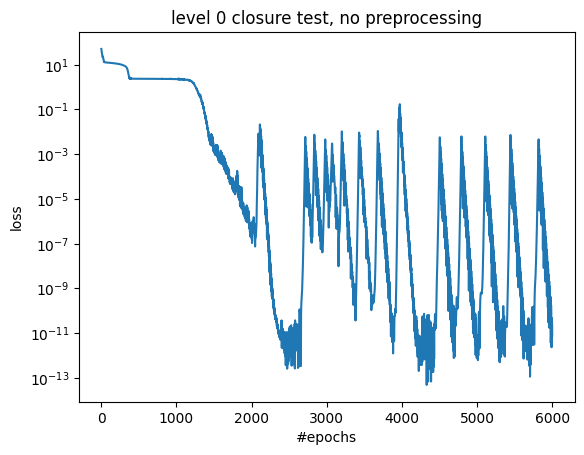

44.416393
12.26779
11.018709
6.931469
2.3577905
2.3537486
2.3537493
2.3558772
2.3537478
2.3672092
2.3537498
2.3537483
2.3543139
2.3537474
2.3537478
2.656677
2.3537505
2.3537486
2.3537483
2.3967252
2.3537486
2.3537478
2.3537478
2.3537488
2.3537621
2.3537483
2.3537476
2.3537486
2.5321398
2.3537488
2.3537483
2.3537488
2.3537526
2.3537636
2.3537476
2.3537486
2.35375
2.3537583
2.3537483
2.3537478
2.353748
2.3537478
2.3541443
2.3537483
2.3537467
2.353748
2.3537488
2.3537474
2.370653
2.353749
2.353747
2.353748
2.3537483
2.3538394
2.3537483
2.3537483
2.3537483
2.3538718
2.35381
2.3537476
6000
reduced chi^2 level 2 = 2.353747606277466
Constrained alpha: 1.0
Constrained beta: 1.0


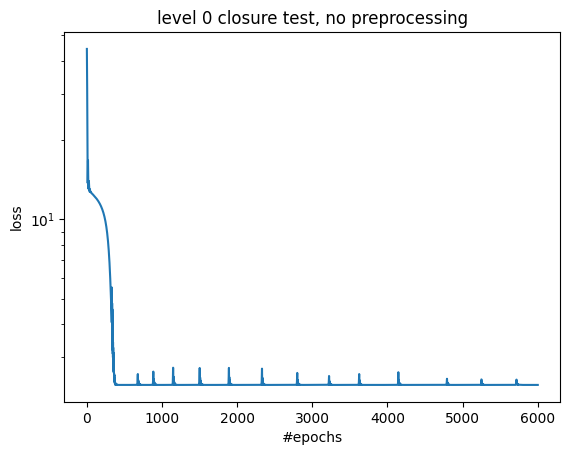

61.304577
12.330032
11.435745
9.359142
2.4409103
2.3431525
2.3404665
2.3403134
2.3285792
2.2445571
2.1294365
1.8255289
1.1945924
0.519122
0.12051647
0.011815089
0.00075528555
3.1897544e-05
2.0735858e-06
3.828293e-09
1.8697958
0.00014800095
7.4578014e-07
5.308265e-09
2.915906e-11
7.71865e-13
6.082671e-13
1.1181039e-12
6.0479844e-13
5.5948887e-13
5.5948887e-13
8.3670784e-07
4.7379904
2.1777496
1.988734
1.7270287
1.2517967
0.8086914
0.42966864
0.1777486
0.062374234
0.00990786
0.0011250162
0.00023900624
1.0810423e-05
1.047363e-06
1.2694288e-08
8.9030083e-10
1.6226229e-10
2.249825e-11
1.5503812e-10
1.10575236e-10
2.2316393e-10
5.714162e-11
1.0023028e-12
0.00068123755
4.1878674e-09
1.6074678e-11
2.9769312e-12
6.81643e-11
6000
reduced chi^2 level 2 = 1.583200931465356e-11
Constrained alpha: 1.0
Constrained beta: 1.0


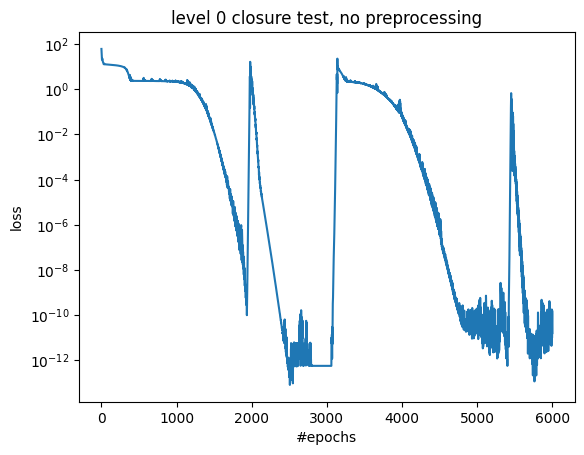

In [12]:
chi_squares,N_event_pred, neutrino_pdfs,model = perform_fit(pred,REPLICAS)

In [13]:
closure_fit = Postfit()
neutrino_pdfs, N_event_pred = closure_fit.apply_postfit_criteria(chi_squares,N_event_pred,neutrino_pdfs)

0.78458256 1.1095673
1.569165 1.1095673
0.78458256 1.1095673


In [14]:
x_vals = x_vals.detach().numpy().flatten()
faser_pdf,x_faser = read_pdf(pdf,x_vals,14) 
# mean_fnu = np.mean(neutrino_pdfs,axis=0) *x_vals
mean_fnu = np.mean(neutrino_pdfs,axis=0) 

mean_pdf_preproc = np.mean(preproc_pdfs,axis=0) 
mean_nn_pdf = np.mean(nn_pdfs,axis=0) 

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


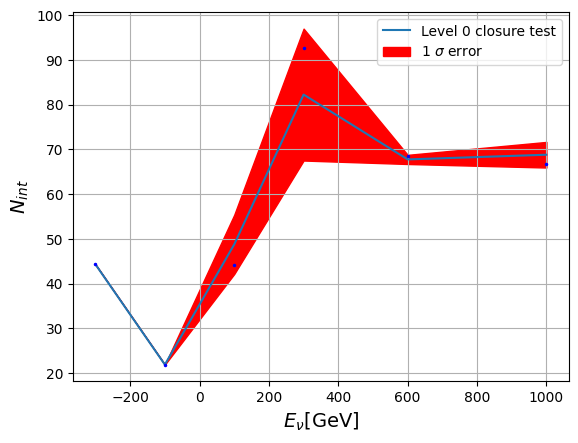

In [15]:

mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)

mean_N_event_fit = mean_N_event_fits.flatten()
sigma_N_event_fit = sigma_N_event_fits.flatten()
xvals_per_obs = np.array(xvals_per_obs)
sorted_indices = np.argsort(xvals_per_obs)

# Sort both arrays using the same indices
sorted_xvals_per_obs = xvals_per_obs[sorted_indices]
sorted_mean_N_event_fit = mean_N_event_fit[sorted_indices]
sorted_sigma_N_event_fit = sigma_N_event_fit[sorted_indices]
level0data = level0[0]
sorted_level0 = level0data[sorted_indices]

plt.plot(sorted_xvals_per_obs,sorted_mean_N_event_fit,label="Level 0 closure test")

plt.fill_between(sorted_xvals_per_obs,(sorted_mean_N_event_fit+sorted_sigma_N_event_fit),(sorted_mean_N_event_fit-sorted_sigma_N_event_fit),label=r"1 $\sigma$ error",color = 'red')

# plt.plot(xvals_per_obs[i],events_per_obs[i],'go',markersize=1.5)
plt.plot(sorted_xvals_per_obs,sorted_level0,'bo',markersize=1.5)
# plt.errorbar(xvals_per_obs[i],events_per_obs[i],yerr=np.sqrt(sig_tot),label='POWHEG +PY8 NLO',color = 'green',alpha=0.6 )
# plt.fill_between(xvals_per_obs[i],events_per_obs[i]+np.sqrt(sig_tot), events_per_obs[i]-np.sqrt(sig_tot),color = 'green',alpha=0.6)
plt.xlabel(r"$E_{\nu}$[GeV]",fontsize = 14)
plt.ylabel(r"$N_{int}$",fontsize = 14)
plt.grid()
plt.legend()
# plt.savefig('N_int_fit.pdf')
plt.show()
    

In [16]:
# from lhapdf_grid import write_lhapdf_grid
# mean_fnu = np.mean(neutrino_pdfs, axis=0) * x_vals
# lhapdfpath = '/opt/anaconda3/envs/nnpdf_dev/share/LHAPDF/enu/enu_0000.dat'

# write_lhapdf_grid(x_vals,mean_fnu,lhapdfpath)

ValueError: x and y must have same first dimension, but have shapes (250,) and (1,)

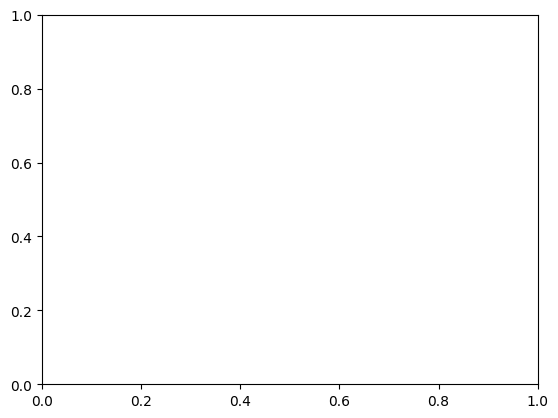

In [17]:
# plt.plot(cont_x,mean_pdf_preproc*mean_nn_pdf*(x_alpha_more_bins.detach().numpy().flatten()),label = 'mult' )
plt.plot(x_vals,mean_fnu,'o',label="fnu",markersize=1.5)
plt.plot(x_vals,mean_pdf_preproc,label="fpreproc",markersize=1.5)
plt.plot(x_vals,mean_nn_pdf,label="fnn",markersize=1.5)
# plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.plot(x_faser,faser_pdf,label ='faserv pdf')
plt.xlabel(r"$x_{\nu}$",fontsize = 14)
plt.ylabel(r"$f_{\nu_e}(x_{\nu})$",fontsize = 14)
plt.ylim(10**-3,10**6)
plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:71: RuntimeWarning: divide by zero encountered in divide
  ratio_center = mean_fnu / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:72: RuntimeWarning: divide by zero encountered in divide
  ratio_lower = (mean_fnu - error_fnu) / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:73: RuntimeWarning: divide by zero encountered in divide
  ratio_upper = (mean_fnu + error_fnu) / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:170: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


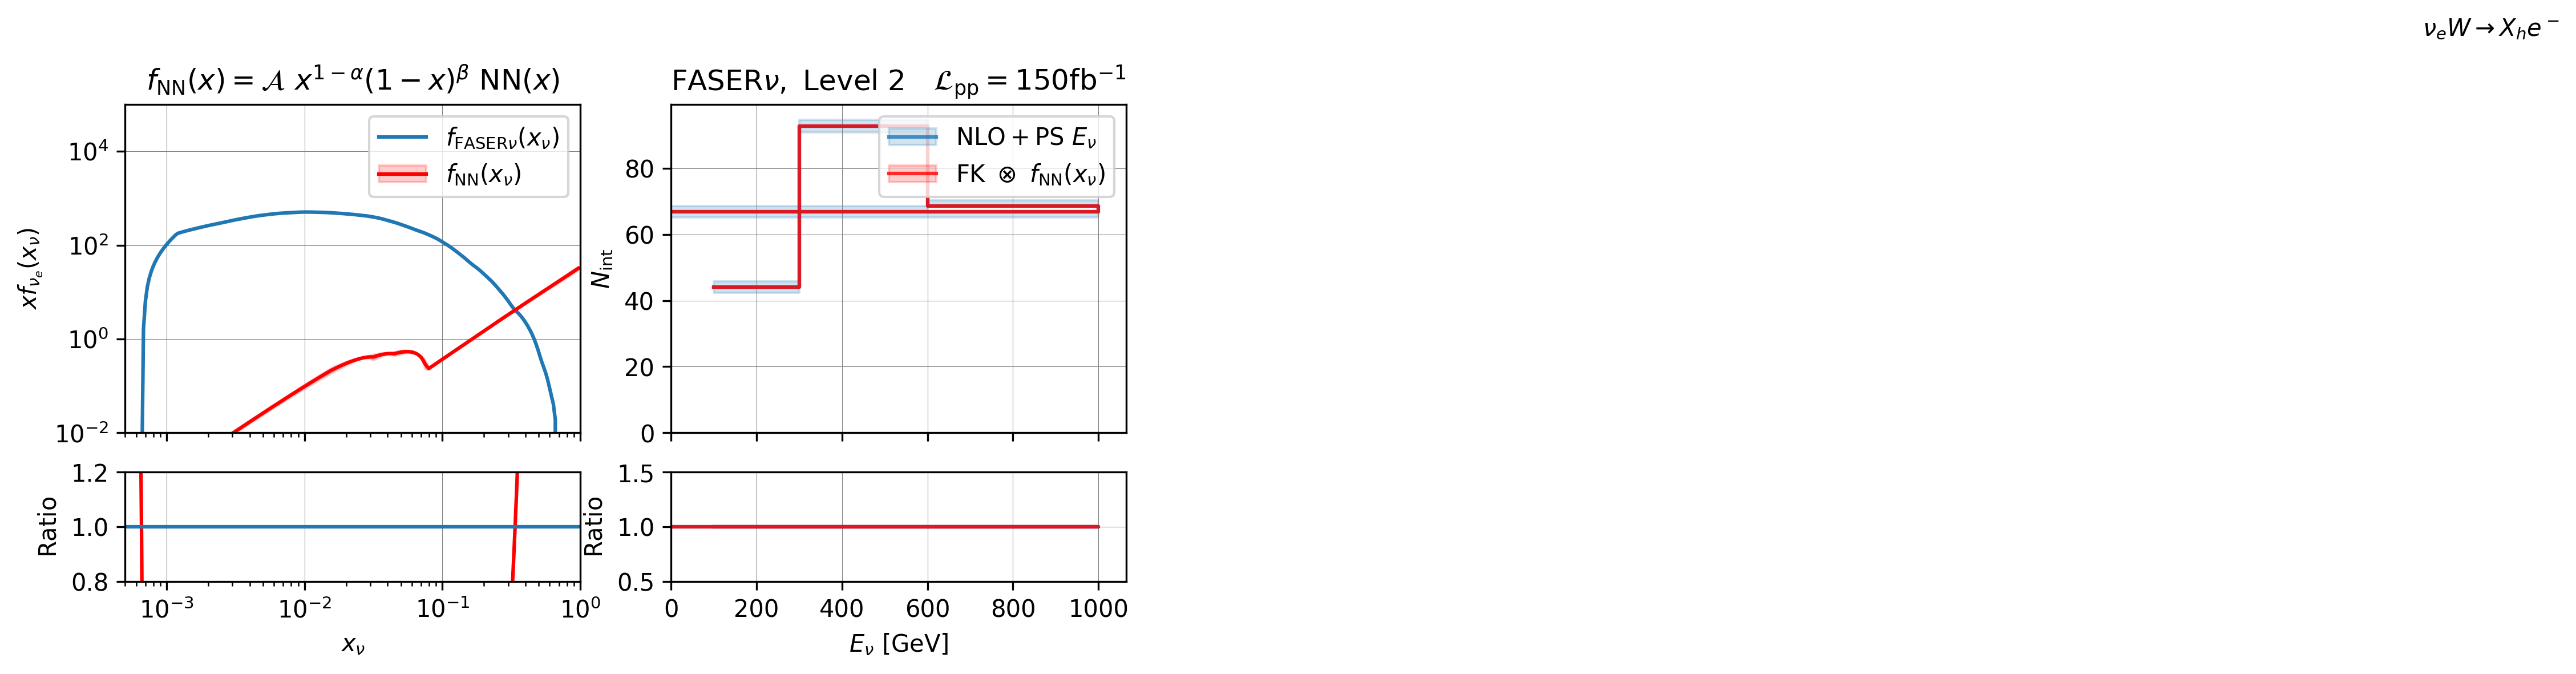

In [ ]:
from plot_results import plot
sig_tot = np.sqrt(sig_sys+sig_stat)
plot(x_vals, neutrino_pdfs, level0, N_event_pred, sig_tot, xvals_per_obs)

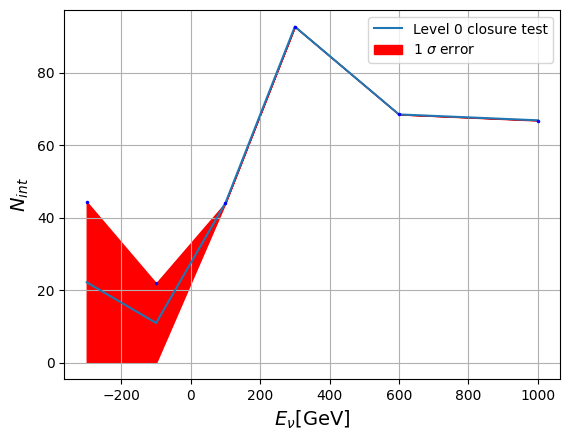

In [ ]:

mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)

mean_N_event_fit = mean_N_event_fits.flatten()
sigma_N_event_fit = sigma_N_event_fits.flatten()
xvals_per_obs = np.array(xvals_per_obs)
sorted_indices = np.argsort(xvals_per_obs)

# Sort both arrays using the same indices
sorted_xvals_per_obs = xvals_per_obs[sorted_indices]
sorted_mean_N_event_fit = mean_N_event_fit[sorted_indices]
sorted_sigma_N_event_fit = sigma_N_event_fit[sorted_indices]
level0data = level0[0]
sorted_level0 = level0data[sorted_indices]

plt.plot(sorted_xvals_per_obs,sorted_mean_N_event_fit,label="Level 0 closure test")

plt.fill_between(sorted_xvals_per_obs,(sorted_mean_N_event_fit+sorted_sigma_N_event_fit),(sorted_mean_N_event_fit-sorted_sigma_N_event_fit),label=r"1 $\sigma$ error",color = 'red')

# plt.plot(xvals_per_obs[i],events_per_obs[i],'go',markersize=1.5)
plt.plot(sorted_xvals_per_obs,sorted_level0,'bo',markersize=1.5)
# plt.errorbar(xvals_per_obs[i],events_per_obs[i],yerr=np.sqrt(sig_tot),label='POWHEG +PY8 NLO',color = 'green',alpha=0.6 )
# plt.fill_between(xvals_per_obs[i],events_per_obs[i]+np.sqrt(sig_tot), events_per_obs[i]-np.sqrt(sig_tot),color = 'green',alpha=0.6)
plt.xlabel(r"$E_{\nu}$[GeV]",fontsize = 14)
plt.ylabel(r"$N_{int}$",fontsize = 14)
plt.grid()
plt.legend()
# plt.savefig('N_int_fit.pdf')
plt.show()
    

In [ ]:
# Quantitative validation of PDF uncertainties in closure tests
# theoretical prediction for # of events
pdf = "faserv"
lowx = -8
n=50
x_vals = generate_grid(lowx,n)

faser_pdf,x_faser = read_pdf(pdf,x_vals)
postfit_measures = Measures(cov_matrix, pdf, N_event_pred)
delta_chi = postfit_measures.compute_delta_chi(num_obs, fk_tables, binwidths, level1[0],x_vals)
print(f'delta chi^2 = {delta_chi}')

phi_chi_squared = postfit_measures.compute_phi(data, chi_squares)
print(f'phi level 2 = {phi_chi_squared}')

dist,xnu  = postfit_measures.compute_distance(neutrino_pdfs,x_vals)
plt.plot(xnu,dist,'o')
plt.ylabel('distance to truth')
plt.xlabel('xnu')
plt.show()

TypeError: read_pdf() missing 1 required positional argument: 'particle'

In [ ]:
def compute_accuracy():
    log_spaced = np.logspace(np.log10(1e-5), np.log10(0.1), 10)
    linear_spaced = np.linspace(0.1, 1, 10)
    x_xi_measure = np.concatenate((log_spaced, linear_spaced))
    x_xi_measure= torch.tensor(x_xi_measure, dtype=torch.float32).view(-1,1)

    pdf = "faserv"

    faser_pdf,x_faser = read_pdf(pdf,x_xi_measure)
    faser_pdf =faser_pdf.detach().numpy().squeeze()

    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level1,REPLICAS=  1)
    mean_neutrino_pdf =model(x_xi_measure).detach().numpy().squeeze()
    
    return mean_neutrino_pdf,faser_pdf,n

# mean_neutrino_pdf,faser_pdf,n = compute_accuracy()
# xi = np.sum(abs(mean_neutrino_pdf-faser_pdf) < error_neutrino_fit)/ n
# print(f'xi = {xi}')

In [ ]:
def compute_bias_to_variance(num_level1_shifts,level0,level1,level2):
    biases = []
    variances = []
    level1 = np.array(level1)
    level0 = np.array(level0)
    diff_level01 = level1 - level0
    level2 -= diff_level01
    level0 = torch.tensor(level0, dtype=torch.float32)
    for i in range(num_level1_shifts):
        
        # generate level2 data with different level 1 shifts
        r_sys = np.random.normal(0, 1) * sig_sys / 10
        r_stat = np.random.normal(0, 1) * np.sqrt(data) / 10
        level2 += r_sys + r_stat
        level2 = torch.tensor(level2, dtype=torch.float32)
        
        arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level2,REPLICAS = 3)
        mean_N_events = np.mean(N_event_pred,axis=0)
        mean_N_events = torch.tensor(mean_N_events, dtype=torch.float32)
        
        mean_chi_square = raw_loss_fct(level0[0],mean_N_events,cov_matrix)
        biases.append(mean_chi_square)

        chi_square_level2 = 0
        for j in range (REPLICAS):
            chi_square_level2 += raw_loss_fct(level2[j],mean_N_events, cov_matrix)
        variances.append(chi_square_level2/REPLICAS)


    exp_bias = np.mean(biases)
    exp_variance = np.mean(variances)
    ratio = exp_bias/exp_variance
    return ratio
    
# ratio = compute_bias_to_variance(1,level0,level1,level2)
# print(f'ratio = {ratio}')


#BIAS:
    # mc reps = level 1 + level 2
    # average over level 1: keep level 2 the same, but add different level 1 shifts
    # compute reduced chi square with respect to level 0 data
    # VARIANCE:
    # mc reps = level 1 + level 2
    # average chi^2 over several level 2 shifts
    # do not average over level 1 shifts since it is expected to be constant
    # Compute reduced chi square with respect to all level 2 replics: so do not have to run a lot more fits it seems
    # however since these multiple level 1 fits have to be run anyway, it is no problemo